In [3]:
import numpy as np 
import pandas as pd 
import os
import torch.utils.data as data_utils
import torchvision.transforms as transforms
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
from torch.utils.data import random_split, DataLoader
from collections import Counter
from torch import optim
from tqdm import tqdm
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

In [4]:
# Reading the dataset after normalizing, converting to tensor and converting each to a standard size
dataset = datasets.ImageFolder('./data/', transform = transforms.Compose([
    transforms.Resize((32,32)), transforms.ToTensor(), transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]))

In [22]:
# Converting the train, val, test split
trainSize = int(0.8*len(dataset))
valSize = (len(dataset) - trainSize)//2
testSize = len(dataset) - trainSize - valSize

trainData, valData, testData = random_split(dataset, [trainSize, valSize, testSize])

trainClasses = [dataset.targets[i] for i in (trainData.indices)]
print('train', Counter(trainClasses))
testClasses = [dataset.targets[i] for i in (testData.indices)]
print('test', Counter(testClasses))
valClasses = [dataset.targets[i] for i in (valData.indices)]
print('val', Counter(valClasses))

print(len(trainData), len(valData), len(testData))

# entering the data into dataloaders
train_loader = DataLoader(trainData, 128, shuffle = True)
test_loader = DataLoader(testData, 128, shuffle = True)
valid_loader = DataLoader(valData, 128, shuffle = True)

train Counter({0: 11032, 1: 11014})
test Counter({0: 1401, 1: 1355})
val Counter({1: 1410, 0: 1346})
22046 2756 2756


In [23]:
def imshow(img):
    '''
    Function to display the image
    '''
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))
    
classes=['infected','uninfected']

/home/mann/.conda/envs/base3.6/lib/python3.6/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


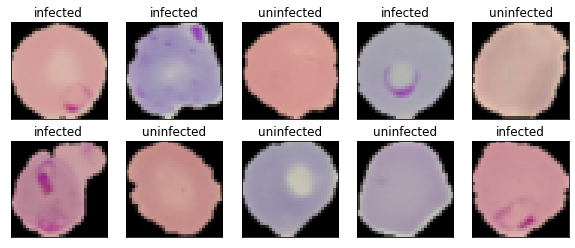

In [25]:
infected = 0
uninfected = 0
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
fig = plt.figure(figsize=(10, 4))
for i in range(len(dataiter)):
    if infected == 5 and uninfected == 5:
        break
    if labels[i] == 0:
        if infected == 5:
            continue
        infected += 1
    else:
        if uninfected == 5:
            continue
        uninfected += 1
    ax = fig.add_subplot(2, 10/2, i+1, xticks=[], yticks=[])
    imshow(images[i])
    ax.set_title(classes[labels[i]])

    


# # plot the images in the batch, along with the corresponding label
# fig = plt.figure(figsize=(25, 4))
# # display 20 images
# for idx in np.arange(20):
#     ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
#     imshow(images[idx])
#     ax.set_title(classes[labels[idx]])

In [117]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1=nn.Conv2d(3,16,kernel_size=9, padding=1)
        self.pool1=nn.MaxPool2d(kernel_size=(3,3),stride=2)
        self.conv2=nn.Conv2d(16,32,kernel_size=6, padding=1)
        self.pool2=nn.MaxPool2d(kernel_size=(3,3),stride=2)
        self.conv3=nn.Conv2d(32,64,kernel_size=3, padding=1)
        self.pool3=nn.MaxPool2d(kernel_size=(3,3),stride=2)
#         self.conv4=nn.Conv2d(64,128,kernel_size=(4,4))
#         self.pool4=nn.MaxPool2d(kernel_size=(3,3),stride=2)
        self.fc1=nn.Linear(1*1*64,32)
#         self.fc2=nn.Linear(500,100)
        self.fc3=nn.Linear(32,1)
        self.dropout=nn.Dropout(0.25)
        
    def forward(self, x):
        
        x=self.pool1(F.relu(self.conv1(x)))
#         x=self.dropout(x)
        x=self.pool2(F.relu(self.conv2(x)))
#         x=self.dropout(x)
        x=self.pool3(F.relu(self.conv3(x)))
#         x=self.dropout(x)
        x=x.reshape( -1,1*1*64)
#         x = x.view(x.size(0), -1)
        x=F.relu(self.fc1(x))
#         x=self.dropout(x)
#         x=F.relu(self.fc2(x))
#         x=self.dropout(x)
        x=F.sigmoid(self.fc3(x))
#         x = self.fc3(x)
        return x

In [118]:
model = Net().to(device)
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(9, 9), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(6, 6), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [119]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)

In [121]:
# number of epochs to train the model
n_epochs = 3

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in tqdm(train_loader):
        # move tensors to GPU if CUDA is available
#         if torch.cuda.is_available():
#         data, target = data.to(device), target.reshape((-1, 1)).to(torch.float32).to(device)
        data, target = data.to(device), target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target.reshape(-1, 1).to(torch.float32))
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
#         if torch.cuda.is_available():
#         data, target = data.to(device), target.reshape((-1, 1)).to(torch.float32).to(device)
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target.reshape(-1, 1).to(torch.float32))
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 0.616655 	Validation Loss: 0.608533
Validation loss decreased (inf --> 0.608533).  Saving model ...


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 0.494265 	Validation Loss: 0.413486
Validation loss decreased (0.608533 --> 0.413486).  Saving model ...


100%|██████████| 173/173 [00:42<00:00,  4.08it/s]


Epoch: 3 	Training Loss: 0.344126 	Validation Loss: 0.332836
Validation loss decreased (0.413486 --> 0.332836).  Saving model ...


In [123]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [128]:

# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval()
# iterate over test data
nCorrect = 0
nSamples = 0
for data, target in tqdm(test_loader):
#     data = data.to(device)
#     target = target.reshape((-1, 1)).to(torch.float32).to(device)
    # move tensors to GPU if CUDA is available
#     if torch.cuda.is_available():
#         data, target = data.cuda(), target.cuda()
#     data = data.to(device)
#     target = target.to(device)
#     data, target = data.to(device), target.reshape((-1, 1)).to(torch.float32).to(device)
    data, target = data.to(device), target.to(device)

    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target.reshape(-1, 1).to(torch.float32))
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
#     _, pred = torch.max(output, 1)    
#     acc = (output.reshape(-1).detach().numpy().round() == target).mean()
    acc = sum(output.reshape(-1).detach().round() == target)

    # compare predictions to true label
#     target = target.to(torch.long)
    nSamples += target.shape[0]
    nCorrect += acc
#     for i in range(len(pred)):
#         if pred[i] == target[i]:
#             nCorrect += 1
#     correct_tensor = pred.eq(target.data.view_as(pred))
#     correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
#     calculate test accuracy for each object class
    
    
#     for i in range(len(target)):
#         label = target.data[i]
#         class_correct[label] += correct[i].item()
#         class_total[label] += 1
    
acc = 100.0 * nCorrect / nSamples
print(f'Accuracy of the network on the 10000 test images: {acc:.2f}%')
    
# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

# for i in range(2):
#     if class_total[i] > 0:
#         print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
#             classes[i], 100 * class_correct[i] / class_total[i],
#             np.sum(class_correct[i]), np.sum(class_total[i])))
#     else:
#         print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

# print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
#     100. * np.sum(class_correct) / np.sum(class_total),
#     np.sum(class_correct), np.sum(class_total)))


100%|██████████| 22/22 [00:05<00:00,  4.23it/s]

Accuracy of the network on the 10000 test images: 85.01%
Test Loss: 0.336026



In [123]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [128]:

# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval()
# iterate over test data
nCorrect = 0
nSamples = 0
for data, target in tqdm(test_loader):
#     data = data.to(device)
#     target = target.reshape((-1, 1)).to(torch.float32).to(device)
    # move tensors to GPU if CUDA is available
#     if torch.cuda.is_available():
#         data, target = data.cuda(), target.cuda()
#     data = data.to(device)
#     target = target.to(device)
#     data, target = data.to(device), target.reshape((-1, 1)).to(torch.float32).to(device)
    data, target = data.to(device), target.to(device)

    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target.reshape(-1, 1).to(torch.float32))
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
#     _, pred = torch.max(output, 1)    
#     acc = (output.reshape(-1).detach().numpy().round() == target).mean()
    acc = sum(output.reshape(-1).detach().round() == target)

    # compare predictions to true label
#     target = target.to(torch.long)
    nSamples += target.shape[0]
    nCorrect += acc
#     for i in range(len(pred)):
#         if pred[i] == target[i]:
#             nCorrect += 1
#     correct_tensor = pred.eq(target.data.view_as(pred))
#     correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
#     calculate test accuracy for each object class
    
    
#     for i in range(len(target)):
#         label = target.data[i]
#         class_correct[label] += correct[i].item()
#         class_total[label] += 1
    
acc = 100.0 * nCorrect / nSamples
print(f'Accuracy of the network on the 10000 test images: {acc:.2f}%')
    
# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

# for i in range(2):
#     if class_total[i] > 0:
#         print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
#             classes[i], 100 * class_correct[i] / class_total[i],
#             np.sum(class_correct[i]), np.sum(class_total[i])))
#     else:
#         print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

# print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
#     100. * np.sum(class_correct) / np.sum(class_total),
#     np.sum(class_correct), np.sum(class_total)))


100%|██████████| 22/22 [00:05<00:00,  4.23it/s]

Accuracy of the network on the 10000 test images: 85.01%
Test Loss: 0.336026



In [101]:
target

tensor([[1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.]], device='cuda:0')

In [100]:
output

tensor([[9.9886e-01],
        [9.9938e-01],
        [9.9112e-01],
        [7.2965e-09],
        [3.6931e-08],
        [2.5272e-11],
        [1.3663e-18],
        [4.8758e-05],
        [5.4083e-06],
        [5.6858e-06],
        [2.3578e-06],
        [9.9803e-01],
        [4.8378e-06],
        [9.9748e-01],
        [4.5690e-07],
        [9.9539e-01],
        [1.1384e-08],
        [9.3385e-02],
        [5.0279e-01],
        [8.4658e-01],
        [3.5975e-01],
        [5.2042e-04],
        [9.7258e-01],
        [3.6088e-03],
        [9.9937e-01],
        [2.6754e-16],
        [1.7479e-12],
        [5.4760e-01],
        [7.4815e-01],
        [3.5020e-24]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [102]:
loss

tensor(0.5655, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [95]:
target = target.reshape((-1, 1))

In [96]:
target.shape

torch.Size([128, 1])

In [ ]:

# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval()
# iterate over test data
nCorrect = 0
nSamples = 0
for data, target in tqdm(test_loader):
#     data = data.to(device)
#     target = target.reshape((-1, 1)).to(torch.float32).to(device)
    # move tensors to GPU if CUDA is available
#     if torch.cuda.is_available():
#         data, target = data.cuda(), target.cuda()
    data, target = data.to(device), target.reshape((-1, 1)).to(torch.float32).to(device)

    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
#     target = target.to(torch.long)
    nSamples += target.shape[0]
    for i in range(len(pred)):
        if pred[i] == target[i]:
            nCorrect += 1
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
#     calculate test accuracy for each object class
    
    
#     for i in range(len(target)):
#         label = target.data[i]
#         class_correct[label] += correct[i].item()
#         class_total[label] += 1
    
acc = 100.0 * nCorrect / nSamples
print(f'Accuracy of the network on the 10000 test images: {acc:.2f}%')
    
# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


In [22]:

# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval()
# iterate over test data
nCorrect = 0
nSamples = 0
for data, target in tqdm(valid_loader):
#     data = data.to(device)
#     target = target.reshape((-1, 1)).to(torch.float32).to(device)
    # move tensors to GPU if CUDA is available
#     if torch.cuda.is_available():
#         data, target = data.cuda(), target.cuda()
    data = data.to(device)
    target = target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
#     target = target.to(torch.long)
    nSamples += target.shape[0]
    for i in range(len(pred)):
        if pred[i] == target[i]:
            nCorrect += 1
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
#     calculate test accuracy for each object class
    
    
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
    
acc = 100.0 * nCorrect / nSamples
print(f'Accuracy of the network on the 10000 test images: {acc:.2f}%')
    
# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


100%|██████████| 22/22 [00:05<00:00,  4.15it/s]

Accuracy of the network on the 10000 test images: 74.60%
Test Loss: 0.519764

Test Accuracy of infected: 61% (853/1395)
Test Accuracy of uninfected: 88% (1203/1361)

Test Accuracy (Overall): 74% (2056/2756)


# Weight Initialization

In [39]:
class Net(nn.Module):
    def __init__(self, weightInit='he'):
        super(Net, self).__init__()
        self.weightType = weightInit
        self.blockA=nn.Conv2d(3,16,kernel_size=9, padding=1)
        self.initializeWeights(self.blockA)
        self.pool1=nn.MaxPool2d(kernel_size=(3,3),stride=2)
        self.blockB=nn.Conv2d(16,32,kernel_size=6, padding=1)
        self.initializeWeights(self.blockB)
        self.pool2=nn.MaxPool2d(kernel_size=(3,3),stride=2)
        self.blockC=nn.Conv2d(32,64,kernel_size=3, padding=1)
        self.initializeWeights(self.blockC)
        self.pool3=nn.MaxPool2d(kernel_size=(3,3),stride=2)
        self.fc1=nn.Linear(1*1*64,32)
        self.initializeWeights(self.fc1)
        self.fc2=nn.Linear(32,2)
        self.initializeWeights(self.fc2)
        
    def forward(self, x):
        x=self.pool1(F.relu(self.blockA(x)))
        x=self.pool2(F.relu(self.blockB(x)))
        x=self.pool3(F.relu(self.blockC(x)))
        x=x.reshape( -1,1*1*64)
        x=F.relu(self.fc1(x))
        x=self.fc2(x)
        return x
    
    def initializeWeights(self, w):
        if self.weightType == 'zero':
            nn.init.zeros_(w.weight)
        elif self.weightType == 'random':
            nn.init.normal_(w.weight)
        else:
            nn.init.kaiming_normal_(w.weight)

Zero Weight

In [43]:
model = Net('zero').to(device)
print(model)

Net(
  (blockA): Conv2d(3, 16, kernel_size=(9, 9), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (blockB): Conv2d(16, 32, kernel_size=(6, 6), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (blockC): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)


In [44]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)

In [45]:
# number of epochs to train the model
n_epochs = 5

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in tqdm(train_loader):
        # move tensors to GPU if CUDA is available
#         if torch.cuda.is_available():
        data, target = data.to(device), target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
#         if torch.cuda.is_available():
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_weight_zero.pt')
        valid_loss_min = valid_loss

  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 0.693035 	Validation Loss: 0.691320
Validation loss decreased (inf --> 0.691320).  Saving model ...


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 0.680159 	Validation Loss: 0.667477
Validation loss decreased (0.691320 --> 0.667477).  Saving model ...


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 0.648948 	Validation Loss: 0.636726
Validation loss decreased (0.667477 --> 0.636726).  Saving model ...


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 0.617013 	Validation Loss: 0.611209
Validation loss decreased (0.636726 --> 0.611209).  Saving model ...


100%|██████████| 173/173 [00:40<00:00,  4.29it/s]


Epoch: 5 	Training Loss: 0.593453 	Validation Loss: 0.603700
Validation loss decreased (0.611209 --> 0.603700).  Saving model ...


In [46]:
model.load_state_dict(torch.load('model_weight_zero.pt'))

<All keys matched successfully>

In [47]:

# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval()
# iterate over test data
nCorrect = 0
nSamples = 0
for data, target in tqdm(test_loader):
#     data = data.to(device)
#     target = target.reshape((-1, 1)).to(torch.float32).to(device)
    # move tensors to GPU if CUDA is available
#     if torch.cuda.is_available():
#         data, target = data.cuda(), target.cuda()
    data = data.to(device)
    target = target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
#     target = target.to(torch.long)
    nSamples += target.shape[0]
    for i in range(len(pred)):
        if pred[i] == target[i]:
            nCorrect += 1
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
#     calculate test accuracy for each object class
    
    
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
    
acc = 100.0 * nCorrect / nSamples
print(f'Accuracy of the network on the 10000 test images: {acc:.2f}%')
    
# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


100%|██████████| 22/22 [00:05<00:00,  4.22it/s]

Accuracy of the network on the 10000 test images: 74.09%
Test Loss: 0.592043

Test Accuracy of infected: 67% (928/1375)
Test Accuracy of uninfected: 80% (1114/1381)

Test Accuracy (Overall): 74% (2042/2756)


Random Weight

In [51]:
model = Net('random').to(device)
print(model)

Net(
  (blockA): Conv2d(3, 16, kernel_size=(9, 9), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (blockB): Conv2d(16, 32, kernel_size=(6, 6), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (blockC): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)


In [52]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)

In [53]:
# number of epochs to train the model
n_epochs = 5

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in tqdm(train_loader):
        # move tensors to GPU if CUDA is available
#         if torch.cuda.is_available():
        data, target = data.to(device), target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
#         if torch.cuda.is_available():
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_weight_random.pt')
        valid_loss_min = valid_loss

  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 9300.056273 	Validation Loss: 4391.250725
Validation loss decreased (inf --> 4391.250725).  Saving model ...


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 3635.946136 	Validation Loss: 3115.334410
Validation loss decreased (4391.250725 --> 3115.334410).  Saving model ...


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 2797.942251 	Validation Loss: 2609.015476
Validation loss decreased (3115.334410 --> 2609.015476).  Saving model ...


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 2364.879982 	Validation Loss: 2301.092736
Validation loss decreased (2609.015476 --> 2301.092736).  Saving model ...


100%|██████████| 173/173 [00:40<00:00,  4.26it/s]


Epoch: 5 	Training Loss: 2051.863524 	Validation Loss: 2034.970966
Validation loss decreased (2301.092736 --> 2034.970966).  Saving model ...


In [54]:
model.load_state_dict(torch.load('model_weight_random.pt'))

<All keys matched successfully>

In [55]:

# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval()
# iterate over test data
nCorrect = 0
nSamples = 0
for data, target in tqdm(test_loader):
#     data = data.to(device)
#     target = target.reshape((-1, 1)).to(torch.float32).to(device)
    # move tensors to GPU if CUDA is available
#     if torch.cuda.is_available():
#         data, target = data.cuda(), target.cuda()
    data = data.to(device)
    target = target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
#     target = target.to(torch.long)
    nSamples += target.shape[0]
    for i in range(len(pred)):
        if pred[i] == target[i]:
            nCorrect += 1
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
#     calculate test accuracy for each object class
    
    
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
    
acc = 100.0 * nCorrect / nSamples
print(f'Accuracy of the network on the 10000 test images: {acc:.2f}%')
    
# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


100%|██████████| 22/22 [00:05<00:00,  4.29it/s]

Accuracy of the network on the 10000 test images: 62.99%
Test Loss: 2100.967022

Test Accuracy of infected: 58% (799/1375)
Test Accuracy of uninfected: 67% (937/1381)

Test Accuracy (Overall): 62% (1736/2756)


He Weight

In [56]:
model = Net('he').to(device)
print(model)

Net(
  (blockA): Conv2d(3, 16, kernel_size=(9, 9), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (blockB): Conv2d(16, 32, kernel_size=(6, 6), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (blockC): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)


In [57]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)

In [58]:
# number of epochs to train the model
n_epochs = 5

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in tqdm(train_loader):
        # move tensors to GPU if CUDA is available
#         if torch.cuda.is_available():
        data, target = data.to(device), target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
#         if torch.cuda.is_available():
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_weight_he.pt')
        valid_loss_min = valid_loss

  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 0.548032 	Validation Loss: 0.475209
Validation loss decreased (inf --> 0.475209).  Saving model ...


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 0.435565 	Validation Loss: 0.417525
Validation loss decreased (0.475209 --> 0.417525).  Saving model ...


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 0.379032 	Validation Loss: 0.363930
Validation loss decreased (0.417525 --> 0.363930).  Saving model ...


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 0.336817 	Validation Loss: 0.324920
Validation loss decreased (0.363930 --> 0.324920).  Saving model ...


100%|██████████| 173/173 [00:40<00:00,  4.30it/s]


Epoch: 5 	Training Loss: 0.284262 	Validation Loss: 0.321741
Validation loss decreased (0.324920 --> 0.321741).  Saving model ...


In [59]:
model.load_state_dict(torch.load('model_weight_he.pt'))

<All keys matched successfully>

In [60]:

# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval()
# iterate over test data
nCorrect = 0
nSamples = 0
for data, target in tqdm(test_loader):
#     data = data.to(device)
#     target = target.reshape((-1, 1)).to(torch.float32).to(device)
    # move tensors to GPU if CUDA is available
#     if torch.cuda.is_available():
#         data, target = data.cuda(), target.cuda()
    data = data.to(device)
    target = target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
#     target = target.to(torch.long)
    nSamples += target.shape[0]
    for i in range(len(pred)):
        if pred[i] == target[i]:
            nCorrect += 1
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
#     calculate test accuracy for each object class
    
    
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
    
acc = 100.0 * nCorrect / nSamples
print(f'Accuracy of the network on the 10000 test images: {acc:.2f}%')
    
# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


100%|██████████| 22/22 [00:05<00:00,  4.25it/s]

Accuracy of the network on the 10000 test images: 86.28%
Test Loss: 0.313750

Test Accuracy of infected: 93% (1288/1375)
Test Accuracy of uninfected: 78% (1090/1381)

Test Accuracy (Overall): 86% (2378/2756)


# Dropout

In [39]:
class Net(nn.Module):
    def __init__(self, weightInit='he'):
        super(Net, self).__init__()
        self.weightType = weightInit
        self.blockA=nn.Conv2d(3,16,kernel_size=9, padding=1)
        self.initializeWeights(self.blockA)
        self.pool1=nn.MaxPool2d(kernel_size=(3,3),stride=2)
        self.blockB=nn.Conv2d(16,32,kernel_size=6, padding=1)
        self.initializeWeights(self.blockB)
        self.pool2=nn.MaxPool2d(kernel_size=(3,3),stride=2)
        self.blockC=nn.Conv2d(32,64,kernel_size=3, padding=1)
        self.initializeWeights(self.blockC)
        self.pool3=nn.MaxPool2d(kernel_size=(3,3),stride=2)
        self.fc1=nn.Linear(1*1*64,32)
        self.initializeWeights(self.fc1)
        self.fc2=nn.Linear(32,2)
        self.initializeWeights(self.fc2)
        
    def forward(self, x):
        x=self.pool1(F.relu(self.blockA(x)))
        x=self.pool2(F.relu(self.blockB(x)))
        x=self.pool3(F.relu(self.blockC(x)))
        x=x.reshape( -1,1*1*64)
        x=F.relu(self.fc1(x))
        x=self.fc2(x)
        return x
    
    def initializeWeights(self, w):
        if self.weightType == 'zero':
            nn.init.zeros_(w.weight)
        elif self.weightType == 'random':
            nn.init.normal_(w.weight)
        else:
            nn.init.kaiming_normal_(w.weight)

# L2 Regularization

In [133]:
class Net(nn.Module):
    def __init__(self, weightInit='he'):
        super(Net, self).__init__()
        self.weightType = weightInit
        self.blockA=nn.Conv2d(3,16,kernel_size=9, padding=1)
        self.initializeWeights(self.blockA)
        self.pool1=nn.MaxPool2d(kernel_size=(3,3),stride=2)
        self.blockB=nn.Conv2d(16,32,kernel_size=6, padding=1)
        self.initializeWeights(self.blockB)
        self.pool2=nn.MaxPool2d(kernel_size=(3,3),stride=2)
        self.blockC=nn.Conv2d(32,64,kernel_size=3, padding=1)
        self.initializeWeights(self.blockC)
        self.pool3=nn.MaxPool2d(kernel_size=(3,3),stride=2)
        self.fc1=nn.Linear(1*1*64,32)
        self.initializeWeights(self.fc1)
        self.fc2=nn.Linear(32,1)
        self.initializeWeights(self.fc2)
        self.dropout=nn.Dropout(0.25)
        
    def forward(self, x):
        x=self.pool1(F.relu(self.blockA(x)))
        x=self.pool2(F.relu(self.blockB(x)))
        x=self.pool3(F.relu(self.blockC(x)))
        x=x.reshape( -1,1*1*64)
        x=F.relu(self.fc1(x))
        x=self.dropout(x)
        x=F.sigmoid(self.fc2(x))
        return x
    
    def initializeWeights(self, w):
        if self.weightType == 'zero':
            nn.init.zeros_(w.weight)
        elif self.weightType == 'random':
            nn.init.normal_(w.weight)
        else:
            nn.init.kaiming_normal_(w.weight)

In [134]:
model = Net().to(device)
print(model)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5)

Net(
  (blockA): Conv2d(3, 16, kernel_size=(9, 9), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (blockB): Conv2d(16, 32, kernel_size=(6, 6), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (blockC): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [135]:
# number of epochs to train the model
n_epochs = 5

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in tqdm(train_loader):
        # move tensors to GPU if CUDA is available
#         if torch.cuda.is_available():
#         data, target = data.to(device), target.reshape((-1, 1)).to(torch.float32).to(device)
        data, target = data.to(device), target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target.reshape(-1, 1).to(torch.float32))
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
#         if torch.cuda.is_available():
#         data, target = data.to(device), target.reshape((-1, 1)).to(torch.float32).to(device)
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target.reshape(-1, 1).to(torch.float32))
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 0.581820 	Validation Loss: 0.518495
Validation loss decreased (inf --> 0.518495).  Saving model ...


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 0.462264 	Validation Loss: 0.417355
Validation loss decreased (0.518495 --> 0.417355).  Saving model ...


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 0.403889 	Validation Loss: 0.375760
Validation loss decreased (0.417355 --> 0.375760).  Saving model ...


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 0.348860 	Validation Loss: 0.320413
Validation loss decreased (0.375760 --> 0.320413).  Saving model ...


100%|██████████| 173/173 [00:42<00:00,  4.08it/s]


Epoch: 5 	Training Loss: 0.312027 	Validation Loss: 0.299002
Validation loss decreased (0.320413 --> 0.299002).  Saving model ...


In [136]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [137]:

# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval()
# iterate over test data
nCorrect = 0
nSamples = 0
for data, target in tqdm(test_loader):
#     data = data.to(device)
#     target = target.reshape((-1, 1)).to(torch.float32).to(device)
    # move tensors to GPU if CUDA is available
#     if torch.cuda.is_available():
#         data, target = data.cuda(), target.cuda()
#     data = data.to(device)
#     target = target.to(device)
#     data, target = data.to(device), target.reshape((-1, 1)).to(torch.float32).to(device)
    data, target = data.to(device), target.to(device)

    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target.reshape(-1, 1).to(torch.float32))
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
#     _, pred = torch.max(output, 1)    
#     acc = (output.reshape(-1).detach().numpy().round() == target).mean()
    acc = sum(output.reshape(-1).detach().round() == target)

    # compare predictions to true label
#     target = target.to(torch.long)
    nSamples += target.shape[0]
    nCorrect += acc
#     for i in range(len(pred)):
#         if pred[i] == target[i]:
#             nCorrect += 1
#     correct_tensor = pred.eq(target.data.view_as(pred))
#     correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
#     calculate test accuracy for each object class
    
    
#     for i in range(len(target)):
#         label = target.data[i]
#         class_correct[label] += correct[i].item()
#         class_total[label] += 1
    
acc = 100.0 * nCorrect / nSamples
print(f'Accuracy of the network on the 10000 test images: {acc:.2f}%')
    
# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

# for i in range(2):
#     if class_total[i] > 0:
#         print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
#             classes[i], 100 * class_correct[i] / class_total[i],
#             np.sum(class_correct[i]), np.sum(class_total[i])))
#     else:
#         print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

# print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
#     100. * np.sum(class_correct) / np.sum(class_total),
#     np.sum(class_correct), np.sum(class_total)))


100%|██████████| 22/22 [00:05<00:00,  4.37it/s]

Accuracy of the network on the 10000 test images: 87.59%
Test Loss: 0.297205



# L1 Reg

In [140]:
model = Net().to(device)
print(model)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)

Net(
  (blockA): Conv2d(3, 16, kernel_size=(9, 9), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (blockB): Conv2d(16, 32, kernel_size=(6, 6), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (blockC): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [141]:
# number of epochs to train the model
n_epochs = 5
l1_lambda = 1e-3
valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # train the model #
    ###################
    model.train()
    for data, target in tqdm(train_loader):
        # move tensors to GPU if CUDA is available
#         if torch.cuda.is_available():
#         data, target = data.to(device), target.reshape((-1, 1)).to(torch.float32).to(device)
        data, target = data.to(device), target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target.reshape(-1, 1).to(torch.float32))
        # backward pass: compute gradient of the loss with respect to model parameters
        l1_norm = sum(abs(p).sum() for p in model.parameters())
        loss = loss + l1_lambda * l1_norm
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
#         if torch.cuda.is_available():
#         data, target = data.to(device), target.reshape((-1, 1)).to(torch.float32).to(device)
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target.reshape(-1, 1).to(torch.float32))
        l1_norm = sum(abs(p).sum() for p in model.parameters())
        loss = loss + l1_lambda * l1_norm
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 2.854335 	Validation Loss: 2.359871
Validation loss decreased (inf --> 2.359871).  Saving model ...


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 2.031510 	Validation Loss: 1.765519
Validation loss decreased (2.359871 --> 1.765519).  Saving model ...


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 1.553603 	Validation Loss: 1.379570
Validation loss decreased (1.765519 --> 1.379570).  Saving model ...


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 1.252325 	Validation Loss: 1.144587
Validation loss decreased (1.379570 --> 1.144587).  Saving model ...


100%|██████████| 173/173 [00:43<00:00,  4.02it/s]


Epoch: 5 	Training Loss: 1.082577 	Validation Loss: 0.990792
Validation loss decreased (1.144587 --> 0.990792).  Saving model ...


In [142]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [143]:

# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval()
# iterate over test data
nCorrect = 0
nSamples = 0
for data, target in tqdm(test_loader):
#     data = data.to(device)
#     target = target.reshape((-1, 1)).to(torch.float32).to(device)
    # move tensors to GPU if CUDA is available
#     if torch.cuda.is_available():
#         data, target = data.cuda(), target.cuda()
#     data = data.to(device)
#     target = target.to(device)
#     data, target = data.to(device), target.reshape((-1, 1)).to(torch.float32).to(device)
    data, target = data.to(device), target.to(device)

    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target.reshape(-1, 1).to(torch.float32))
    l1_norm = sum(abs(p).sum() for p in model.parameters())
    loss = loss + l1_lambda * l1_norm
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
#     _, pred = torch.max(output, 1)    
#     acc = (output.reshape(-1).detach().numpy().round() == target).mean()
    acc = sum(output.reshape(-1).detach().round() == target)

    # compare predictions to true label
#     target = target.to(torch.long)
    nSamples += target.shape[0]
    nCorrect += acc
#     for i in range(len(pred)):
#         if pred[i] == target[i]:
#             nCorrect += 1
#     correct_tensor = pred.eq(target.data.view_as(pred))
#     correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
#     calculate test accuracy for each object class
    
    
#     for i in range(len(target)):
#         label = target.data[i]
#         class_correct[label] += correct[i].item()
#         class_total[label] += 1
    
acc = 100.0 * nCorrect / nSamples
print(f'Accuracy of the network on the 10000 test images: {acc:.2f}%')
    
# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

# for i in range(2):
#     if class_total[i] > 0:
#         print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
#             classes[i], 100 * class_correct[i] / class_total[i],
#             np.sum(class_correct[i]), np.sum(class_total[i])))
#     else:
#         print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

# print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
#     100. * np.sum(class_correct) / np.sum(class_total),
#     np.sum(class_correct), np.sum(class_total)))


100%|██████████| 22/22 [00:05<00:00,  4.21it/s]

Accuracy of the network on the 10000 test images: 84.91%
Test Loss: 0.992048

